# Principal Components Analysis

In a *supervised* learning problem we seek to predict a label from a set of features.  If the label we are predicting is a continuous, we call it regression problem.  If the label is discrete, we call it a classification problem.

We now turn our attention to *unsupervised* learning.  The goal of unsupervised learning is not to predict a label from features. Rather, it is to discover interesting or useful things about the features themselves.  In comparison to supervised learning, unsupervised learning is more ambiguous and therefore more difficult.  Determining what is *interesting* about your features is quite subjective, and it is hard to assess how successfully you have discovered those interesting things.
  
Unsupervised learning is often used in the exploratory data analysis process, or as a data preprocessing step to a supervised learning problem.

This chapter is an intuitive introduction to principal components analysis (PCA), which is an technique used to reduced the dimensionality of a set of features.  In particular, we apply this technique to VIX term structure data.

## Import Packages

Let's begin by loading the packages that we will need.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Reading-In Data

Next, let's read-in our data; this is the same data set that we used in the k-nearest-neighbors chapter.

In [ ]:
df_vix = pd.read_csv('vix_knn.csv')
df_vix = df_vix[df_vix.trade_date > '2011-01-03'] #removing the first row of NaNs
df_vix.drop(['spy_ret'], axis=1, inplace=True) # dropping the returns (label) column
df_vix.head()

,trade_date,vix_009,vix_030,vix_090,vix_180
1,2011-01-04,0.02,-0.23,-0.01,-0.21
2,2011-01-05,-0.49,-0.36,-0.56,-0.41
3,2011-01-06,0.14,0.38,0.30,0.09
4,2011-01-07,-0.70,-0.26,-0.06,0.05
5,2011-01-10,0.80,0.40,0.19,0.01


Recall that this data set is the daily changes for various points along the implied volatility term structure.  We'll also be interested in the absolute levels of the VIX term structure, so let's import that data now.

In [ ]:
df_vix_ts = pd.read_csv('vix_term_structure.csv')
df_vix_ts.drop(['spy_ret'], axis=1, inplace=True) # dropping returns column
df_vix_ts.head()

,trade_date,vix_009,vix_030,vix_090,vix_180
0,2011-01-03,16.04,17.61,20.62,23.40
1,2011-01-04,16.06,17.38,20.61,23.19
2,2011-01-05,15.57,17.02,20.05,22.78
3,2011-01-06,15.71,17.40,20.35,22.87
4,2011-01-07,15.01,17.14,20.29,22.92


## Typical Term Structure

It is useful to think of both `df_vix` and `df_vix_ts` as living in Euclidean space.  However, they mostly live in certain specific subspaces of Euclidean space, and it's the goal of PCA to give this observation a more specific meaning.  

Before we dive into the specifics of PCA, let's develop an intuition for what a typical VIX term structure looks like, and what kind of daily changes are typical in the term structure.

The first stylized fact about the VIX term structure is that it is usually monotonically increasing.  We can check this with the following code.

In [ ]:
cond1 = (df_vix_ts.vix_009 <= df_vix_ts.vix_030)
cond2 = (df_vix_ts.vix_030 <= df_vix_ts.vix_090)
cond3 = (df_vix_ts.vix_090 <= df_vix_ts.vix_180)

df_vix_ts[cond1 & cond2 & cond3].shape[0] / df_vix_ts.shape[0]

0.6923459244532804

Notice that about 70% of days in our data set have an unpwardly sloping term struture.

---

**Code Challenge:** Find the percentage of days in which the 9-day VIX is greater than the 180-day VIX (we'll refer to this as an inverted VIX term structure).

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
cond = (df_vix_ts.vix_009 > df_vix_ts.vix_180)
df_vix_ts[cond].shape[0] / df_vix_ts.shape[0]

0.11083499005964215

---

## Typical Term-Structure Changes

Next we perform a similar analysis on the daily VIX changes, which are stored in `df_vix`.  The following code shows that on 75% of days, all the points on the VIX term structure either rise or fall together.

In [ ]:
# decreasing
cond1 = (df_vix.vix_009 <= 0) 
cond2 = (df_vix.vix_030 <= 0)
cond3 = (df_vix.vix_090 <= 0)
cond4 = (df_vix.vix_180 <= 0)

# increasing
cond5 = (df_vix.vix_009 >= 0) 
cond6 = (df_vix.vix_030 >= 0)
cond7 = (df_vix.vix_090 >= 0)
cond8 = (df_vix.vix_180 >= 0)


cond = (cond1 & cond2 & cond3 & cond4) | (cond5 & cond6 & cond7 & cond8)


df_vix[cond].shape[0] / df_vix.shape[0]

0.7454002983590253

This is also reflected in the strong positive correlations that we can observe in the following **seaborn** pair plot. 

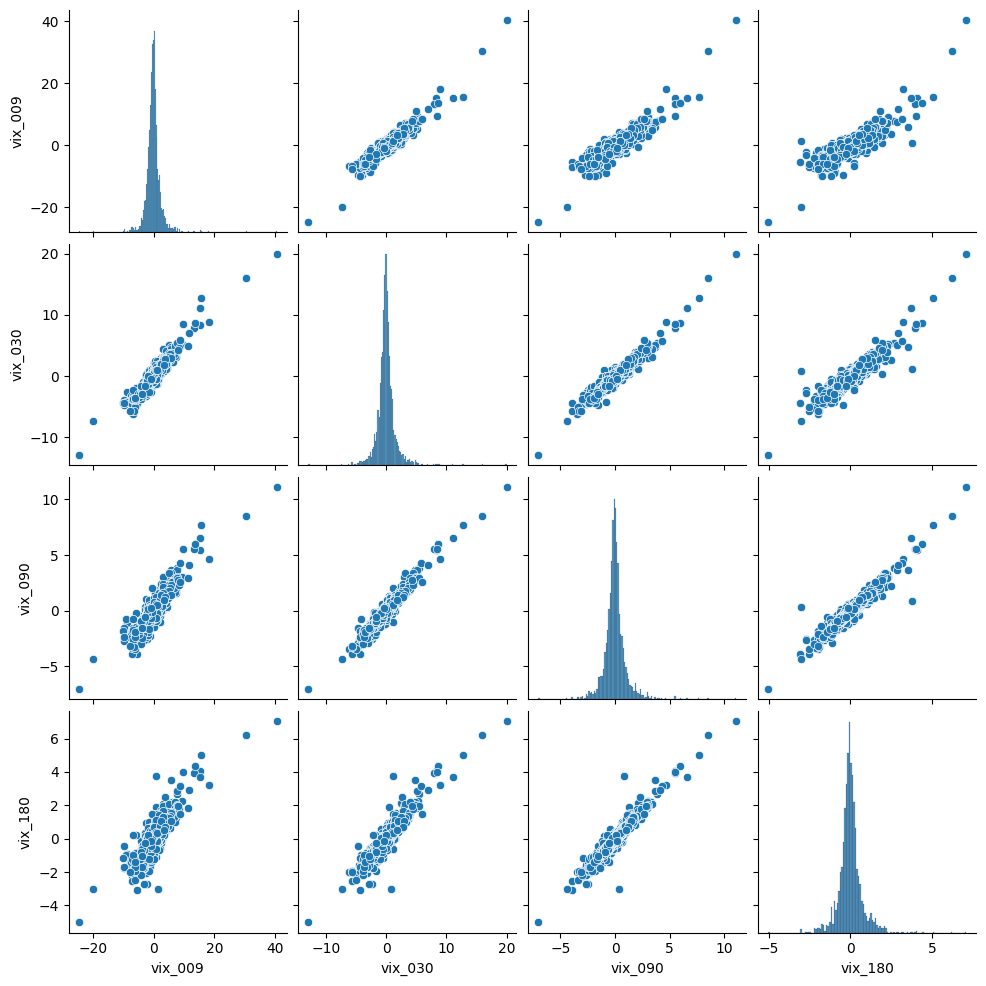

In [ ]:
sns.pairplot(df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]);

## Summarizing Our Observations

Let's summarize our observations from above:

1. About 70% of the time the VIX term structure is monotonically increasing.

2. About 10% of the time the VIX term structure is inverted with 9-day greater than 180-day.

3. On 75% of days, all points on the term structure either rise or fall together.

---

**Discussion Question:** If you were to construct a forecasting model for the VIX, would your model assert that all points of the term structure move completely independently of one another?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# Clearly no.  Most of the time there is a parallel shift, 
# so any model should account for that. 

--- 

## PCA Overview

The purpose of this chapter is to give an intuitive introduction to PCA and how to implement it in **sklearn**.  We are not going to get into the mathematical specifics, which involve a fair amount of linear algebra.  

Instead, here is an overview of the essential ideas:

1. In PCA we are trying to understand a $n$ sized set of $p$-dimensional features. Each of the $n$ feature observations is a vector of $p$ numbers.  It is usually best to scale the features so that each component has mean zero and standard deviation 1.

2. We can think of our feature set as a collection of points living in $p$-dimensional euclidean space ($R^{p}$), with the points being centered around the origin.

3. It is often the case that there is some $q$ that is smaller than $p$, such that most of the variation of the features can be described by a $q$ dimensional linear subspace of ${R}^p$.

4. PCA is a technique for finding the basis of this $q$ dimensional subspace.

5. The first element of this basis is the vector (which defines a line that goes through the origin) that is collectively closest to all of the feature observations.  This is conceptually similar to fitting a regression line.  This vector is called the *first principal component*.  It has the property that if we project our feature observation onto that vector, the sample variance of the projections is maximized.

6. The second element of this basis is called the *second principal* component.  It is found by considering all vectors which are perpendicular to the first principle component.  Among these perpendicular vectors, the second component is the one which bests fits the the feature observations.  It has the property that if we project our feature observations onto that vector, then we maximize the sample variance of the projections (among all vectors that are perpendicular to the first principle component).

7. We repeat this algorithm until we arrive at $q$ principle components.

## Performing a PCA on the VIX Changes

Let's now perform a PCA on our `df_vix` data set using **sklearn**.

We'll begin by normaling our features so that they have mean zero and unity standard deviation.

In [ ]:
from sklearn.preprocessing import scale

# feature selection
X = df_vix[['vix_009', 'vix_030', 'vix_090', 'vix_180']]

# scaling fetures
Xs = scale(X)

Next, we'll instantiate our pca model and then fit it for $q = 3$ components.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(Xs)

PCA(n_components=3)

We can view the actual principal components by printing the `.components` property our model.

In [ ]:
print(pca.components_)

[[ 0.48854882  0.50863285  0.5063361   0.49622216]
 [ 0.73980156  0.15854235 -0.30757946 -0.57702067]
 [-0.40057447  0.53375678  0.4395292  -0.60121367]]


To see what percentage of the overall variation is explained by each of the components, we print the `.explained_variance_ratio` property.

In [ ]:
print(pca.explained_variance_ratio_)

[0.94602979 0.04134279 0.00840214]


Notice that 95% the total variance is explained by the first component. 

---

**Code Challenge:** Try refitting the PCA with `n_components=4`.

1. Are the first three components the same as before?

1. What is the total amount of variance explained by the four componets?

1. What happens when you set `n_components=5` and try to refit?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(Xs)
print("Components:")
print(pca.components_)
print(" ")
print("Variance Explaned:")
print(pca.explained_variance_ratio_)

Components:
[[ 0.48854882  0.50863285  0.5063361   0.49622216]
 [ 0.73980156  0.15854235 -0.30757946 -0.57702067]
 [-0.40057447  0.53375678  0.4395292  -0.60121367]
 [-0.23141694  0.65670438 -0.67515385  0.24362438]]
 
Variance Explaned:
[0.94602979 0.04134279 0.00840214 0.00422528]


---

## Understanding the First Three Principal Components: Level, Slope, Curvature

Let's again look at the first three principal components.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(Xs)
print("Components:")
print(pca.components_)
print(" ")
print("Variance Explaned:")
print(pca.explained_variance_ratio_)

Components:
[[ 0.48854882  0.50863285  0.5063361   0.49622216]
 [ 0.73980156  0.15854235 -0.30757946 -0.57702067]
 [-0.40057447  0.53375678  0.4395292  -0.60121367]]
 
Variance Explaned:
[0.94602979 0.04134279 0.00840214]


These components have a very intuitive interpration (which is not always the case in PCA):

1. **Level:** the first component represents parallel shifts in the VIX term structure - all points increasing or all decreasing.
    - 95% of total variance explained
    - this means that all the points of the term structure are strongly positively correlated
    - we can see this in our pair-plots above, as well as the fact that 75% of days had all points going up or all points going down
    
    
2. **Slope:** the second component represents the front of the curve going up, and the back of the curve going down.
    - explains 4% of total variance
    - recall that about 70% of days had an upward sloping term structure, and 10% of all days had a downward sloping term structure
    - in order for the term structure to go from upward sloping to downward sloping, the curve would need this kind of a move (most likely in conjunction with a parallel shift)
    
    
3. **Curvature:** the third component represnts changes in curvature - moving from more concave to more convex.
    - 1% of total variance